# Community stability in a chain network
## Author of this notebook: Shota Shibasaki

This notebook shows the codes to run simulations and anayze the data. See Shibasaki and Mitri (2022) for more details. This manuscript shows the versions of Python3 and the packages.

In [1]:
# import packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.formula.api as smf
import os
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp #ode integration
import matplotlib.pyplot as plt
import itertools
from cliffs_delta import cliffs_delta

os.chdir('./data')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

# Generating data of the two sceinarios

In [4]:
# generate folders and sample growth rates and interaction matrices
def parameter_generate(N=25, c_list=[0.25, 0.5, 1.0], rep=20):
    # generate growth vectors and species interaction matrix
    for i in range(len(c_list)):
        connectance=c_list[i]
        os.mkdir(str('./connectance%.2f' %(connectance)))
        os.chdir(str('./connectance%.2f' %(connectance)))
        for j in range(rep):
            os.mkdir(os.chdir(str('./replicate%d' %(j))))
            os.chdir(os.chdir(str('./replicate%d' %(j))))
            r_down=np.random.uniform(low=0.1, high=2.0, size=(N)) # grwoth upstream
            r_up=np.random.uniform(low=0.1, high=2.0, size=(N)) # growth downstream
            np.savetxt('growthrate_up.csv', r_up, delimiter=',', fmt='%.6f')
            np.savetxt('growthrate_down.csv', r_down, delimiter=',', fmt='%.6f')
            A=np.eye(N) # assuming normal distribution centering 0.0 or off-diagnoal 
            # Note that MINUS A represents interactions
            for k in range(N):
                for l in range(N):
                    if k!=l and np.random.rand()< connectance:
                        A[k,l] = np.random.normal(loc=0.0, scale=0.25)
            np.savetxt('interaction.csv', A, delimiter=',', fmt='%.6f')
    return 0

In [8]:
# running simulations in assembly scenarios
# need to reformulate main_

def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] - np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]-np.dot(A[i, :], x[:N_up]) - np.dot( A[i, :N_down], x[N_up:]))
    return dx


def main_assembly(c_list=[0.25, 0.5,1.00], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], 
                  mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    T=250 # number of invasion
    for i in range(len(c_list)):
        connect=c_list[i]
        os.chdir(str('./connectance%.2f' %(connect)))
        for j in range(replicate):
            os.chdir(str('./replicate%d' %(j)))
            print(str('connectance %.2f replicate %d' %(connect, j)))
            r_up=np.loadtxt('growthrate_up.csv', delimiter=',')
            r_down=np.loadtxt('growthrate_down.csv', delimiter=',')
            A=np.loadtxt('interaction.csv', delimiter=',')
            N=np.size(r_up) # max number of species in each patch
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    os.chdir(str('./rho%.2f_mu%.2f/assembly' %(rho, mu)))
                    # start analysis
                    invasion =[] 
                    stability=[]
                    abundance=np.zeros([T+1, 2*N])
                    #-----------------------------
                    def Invader_selection(x, N, rho, mu):
                        p=np.zeros([2*N])
                        for i in range(np.size(p)):
                            if i<N:
                                # migration to upstream
                                p[i]=rho
                            else:
                                #migration to downstream
                                p[i] = 1-rho + mu* (Comp(x[i-N]))
                        # normalize
                        p=p/np.sum(p)
                        r_val=np.random.rand()
                        val=0.0
                        for i in range(2*N):
                            val+=p[i]
                            if r_val<val:
                                return i
                        return 2*N-1
                    #-----------------------    
                    for t in range(T):
                        x=abundance[t, :]
                        # calculate structural stability and geenrate next abundances
                        stab, x_next_list=Stability_assembly(N, x, r_up, r_down,A, mu, rho)
                        # update community by invasion
                        invader=Invader_selection(x, N, rho, mu)
                        abundance[t+1, :]= x_next_list[invader]
                        stability.append(stab)
                        invasion.append(invader)
                    # calculate stability of final community
                    x=abundance[-1, :]
                    stab, x_next_list=Stability_assembly(N, x, r_up, r_down,A, mu, rho)
                    stability.append(stab)
    
                    # save csv files
                    np.savetxt('invasion.csv', invasion, delimiter=',', fmt='%d')
                    np.savetxt('stability_new.csv', stability, delimiter=',', fmt='%.6f')
                    np.savetxt('abundance.csv', abundance, delimiter=',', fmt='%.6f')
                    os.chdir('../../')
            os.chdir('../')
        os.chdir('../')
    
       

def Stability_assembly(N, x_full, r_up, r_down,A, mu, rho):
    """
    Calculate the structural stability of down stream and 
    results after invasion
    """
    # prob species with positive invasion growth invades to the downstream
    invasion_all=np.size(x_full) # possible patterns of invasion upstream + downstream
    stability=0.0
    x_next=[] # 2dim list of abundance at the next time step
    for i in range(invasion_all):
        x_full2=np.zeros([np.size(x_full)])
        x_full2[i]+=0.01
        sol=solve_ivp(ODE_structured, [0, 300], y0=x_full+x_full2, method='LSODA',
                         t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
        x_f=sol.y[:,-1]
        for k in range(np.size(x_f)):
            if x_f[k]<pow(10, -6):
                x_f[k]=0.0
        x_next.append(x_f)
    # calculate stability
    p=np.zeros([2*N])
    for i in range(np.size(p)):
        if i<N:
            # migration to upstream
            p[i]=rho
        else:
            #migration to downstream
            p[i] = 1-rho + mu* (Comp(x_full[i-N]))
    # normalize
    p=p/np.sum(p)
    for i in range(2*N):
        x_test=x_next[i]
        stability+=p[i]*np.all(Comp(x_test[N:])==Comp(x_full[N:]))        
    return [stability, x_next]
    

       

In [7]:
# running simulations in  designing scenario
# 
def main_design(c_list=[0.25, 0.5,1.00], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], 
                  mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    sampling_num=200
    for i in range(len(c_list)):
        connect=c_list[i]
        os.chdir(str('./connectance%.2f' %(connect)))
        for j in range(replicate):
            os.chdir(str('./replicate%d' %(j)))
            print(str('connectance %.2f replicate %d' %(connect, j)))
            r_up=np.loadtxt('growthrate_up.csv', delimiter=',')
            r_down=np.loadtxt('growthrate_down.csv', delimiter=',')
            A=np.loadtxt('interaction.csv', delimiter=',')
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    #------------------------------------------
                    def target_geenrate(N):
                        # generate target downstreams
                        target_num=np.random.randint(low=1, high=11) # richness of species from 1 to 10
                        init=np.zeros([2*N])
                        sol_composition=Comp(init)
                        while np.sum(sol_composition) !=target_num:
                            target_num=np.random.randint(low=1, high=11) # richness of species from 1 to 10
                            init=np.zeros([2*N])  # initialize
                            target=np.arange(N)
                            np.random.shuffle(target)
                            target=target[:target_num] # chose target_num species to have in downstream comm
                            for i in range(target_num):
                                n=target[i]
                                init[N+n]=0.01
                            # run simulation to check whetehr these downstream species can coexist
                            sol=solve_ivp(ODE_structured, [0, 300], y0=init, method='LSODA',
                                    t_eval=np.linspace(0, 300, 30001), args=[r_up, r_down, A])# ODE integ
                            sol_composition=Comp(sol.y[:, -1])
                        sol_down=sol.y[N:, -1]
                        for k in range(np.size(sol_down)):
                            if sol_down[k]<pow(10, -6):
                                sol_down[k]=0.0
                        return sol_down
                        #------------------------------------------
                    init_down=target_geenrate(N)
                    np.savetxt('target_down.csv', init_down, delimiter=',', fmt='%.6f')
                    # Now we evaluate structural stability given randomly sampled upstream commmunities
                    upstream_com=np.random.randint(low=0, high=2, size=(sampling_num, N))
                    stability=[]
                    invasion=[]
                    for i in range(sampling_num):
                        init_up=0.01*upstream_com[i, :]
                        init=np.concatenate((init_up,init_down))
                        # tested community can maintain downstream community or not?
                        sol=solve_ivp(ODE_structured, [0, 300], y0=init, 
                                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                                      args=[r_up, r_down, A])# ODE integ
                        if np.all(Comp(init)== Comp(sol.y[:, -1])):
                            # calculate sstbaility
                            stab, inv=Stability_design(sol.y[:, -1], r_up, r_down, A, rho, mu)
                            stability.append(stab)
                            invasion.append(inv)
                        else:
                            # as we upstream or downstream composistion cannot be maintined, 
                            # stability cannot be defined
                            stability.append(np.nan)
                            invasion.append(np.nan) # when invasion to downstream
                    # save csv files
                    np.savetxt('stability_new.csv', stability, delimiter=',', fmt='%.6f')
                    np.savetxt('upstream_community.csv', upstream_com, delimiter=',', fmt='%d')         
                    np.savetxt('invasion_stability_new.csv', invasion, delimiter=',', fmt='%.3f')
                    os.chdir('../../')   
            os.chdir('../')
        os.chdir('../')
    return 0
    
def Invasion(invader, N, x_full, r_up, r_down, A):

        inv=np.zeros([2*N])
        inv[invader]=inv[invader]+0.01
        sol=solve_ivp(ODE_structured, [0, 300], y0=x_full+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r_up, r_down, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        sol_down=sol.y[:,-1]
        for k in range(np.size(sol_down)):
            if sol_down[k]<pow(10, -6):
                sol_down[k]=0

        return np.all(Comp(sol_down[N:])==Comp(x_full[N:]))
    
def Stability_design(x_full, r_up, r_down, A, rho, mu):
    """
    Caltulkating structural stability of downstream

    Parameters
    ----------
    x : 1dim array of species abundances in up/downstream communities
    r_up : 1dim array of growth vector in upsteam 
    r_down : 1dim array of grwoth vector in downstream
    A : 2dim array for species interaction (minus A is interaction matrix)
    rho : parmater for migration from pool to upstream vs to downstream
    mu : parmater for migration from upstream to downstream

    Returns  exact structural stability
    -------
    """
    N=np.size(r_up)
    p=np.zeros([2*N])
    # probabilities to migration to upstream and dowstream community
    for i in range(np.size(p)):
        if i<N:
            # migration to upstream
            p[i]=rho
        else:
            #migration to downstream
            p[i] = 1-rho + mu* (Comp(x_full[i-N]))
    # normalize
    p=p/np.sum(p)
    stability=0.0
    inv_stability=0.0
    # invasion_upstream
    for i in range(N):
        # invasion to upstream
        stability+=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
    for i in range(N, 2*N):
        # invasion to downstream
        add=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
        stability+=add
        inv_stability+=add
    return [stability, inv_stability]

In [ ]:
#How many data we have in designing scenario

def main (c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    count=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        print(i)
        for j in range(replicate):
            #print(j)
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(rho_list)):
                    mu=mu_list[l]
                    # we should not consider the case where the downstream is empy
                    os.chdir(str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/designing2' %(connect, j, rho, mu)))
                    stability=np.loadtxt('stability_new.csv', delimiter=',')
                    count.append(np.sum(np.isnan(stability)==False)/len(stability))
                    os.chdir('../../../../')
    return count
count=main()
plt.hist(count, bins=50, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('fractions of coexisting upsteam communities', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.savefig("Designing_SuccessfulSampling.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

# Analyzing longevity of downstream in assembly

In [ ]:
def composition_convert(abundance):
    return abundance>0.00001
def Longevity(c_list, rho_list, mu_list, replicate=20):
    stability_assembly=[]
    longevity=[]
    rel_longevity=[]
    time_list=[]
    conn_list=[]
    rho_samp=[]
    mu_samp=[]
    rep_list=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for j in range(replicate):
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    path=str('./replicate%d/rho%.2f_mu%.2f' %(j, rho, mu))
                    os.chdir(path)
                    # get stability in assembly scenario
                    os.chdir('./assembly')
                    abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    #invasion=np.loadtxt('invasion.csv', delimiter=',', skiprows=0)
                    N=25
                    count=0
                    D=len(stability)
                    for t in range(len(stability)):
                        #assembly
                        if t==0:
                            stability_assembly.append(stability[t]) # initial stability of new composition
                            time_list.append(t)
                            count=0
                        else:
                            composition_prev=composition_convert(abundance[t-1, N:])
                            if np.all(composition_convert(abundance[t, N:]) == composition_prev):
                            # composition downstream does not change
                                 count+=1
                            else:
                                # composition changed
                                longevity.append(count)  # add longevity
                                rel_longevity.append(count/D)
                                time_list.append(t)
                                conn_list.append(connect)
                                rho_samp.append(rho)
                                mu_samp.append(mu)
                                rep_list.append(j)
                                stability_assembly.append(stability[t]) # initial stability of new composition
                                count=0
                                D=len(stability[t:])
                    longevity.append(count)    
                    rel_longevity.append(count/D)
                    conn_list.append(connect)
                    rho_samp.append(rho)
                    mu_samp.append(mu)
                    rep_list.append(j)
                    os.chdir('../')
                    os.chdir('../../')
        os.chdir('../')
    df_assembly=pd.DataFrame({'stability':stability_assembly, "longevity":longevity, 'rel_longevity':rel_longevity,
                             'connectance':conn_list, 'replicate':rep_list, 'rho':rho_samp, 'mu':mu_samp, 'init_time':time_list})
    
    return df_assembly
df= Longevity(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20)
df.to_csv('longevity.csv', index=False)

In [ ]:
df=pd.read_csv('longevity.csv')
from scipy.optimize import curve_fit
def Exp(x, a, b, c):
    return a * np.exp(-b * x)+c
#curve_fit(func, xdata, y)
#0<a<250, -20<b,<10 -1<c<1
popt_exp, pcov_exp=curve_fit(Exp, df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy(), 
                             p0=[1,-0.2,0], bounds=([0,-5, 0], [250, 5, 1]))

In [ ]:
# do some trick to show longevity 0 in logscale
df_new=df
df_new['longevity']+=1
#plot
ax=sns.scatterplot(data=df_new, x='stability', y='longevity',  alpha=0.01, color='#80b1d3')
plt.scatter([], [], label='data', color='#80b1d3')
x=np.linspace(0.0, 1.0, 80)
ax.set(yscale="log") # to show dots
#plt.plot(x, Logistic(x, *popt_log), 'k--', label='logistic')
plt.plot(x, Exp(x, *popt_exp)+0.9, 'k--', linewidth=3, label='exponential fit')
plt.xlabel('initial stability', fontsize=20)
plt.ylabel("longevity", fontsize=20)
plt.legend(loc='upper left', fontsize=16)
plt.ylim(0.8, 300)
plt.xlim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks([1,2, 11, 101],['0', '1', '10', '100'], fontsize=16)
plt.gca().set_rasterized(True)
plt.savefig("stability_longevity_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
print(popt_exp)

# Stability over two migration parameters

In [4]:
def FullData(c_list, rho_list, mu_list, replicate=20):
    stability_design=[]
    mu_design=[]
    rho_design=[]
    connectance_design=[]
    invasion_design=[]
    stability_assembly=[]
    mu_assembly=[]
    rho_assembly=[]
    connectance_assembly=[]
    invasion_assembly=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for j in range(replicate):
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
                    os.chdir(path)
                    # get stability in assembly scenario
                    os.chdir('./assembly')
                    abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    invasion=np.loadtxt('invasion_stability.csv', delimiter=',', skiprows=0)
                    N=25
                    for t in range(len(stability)):
                        #assembly
                        if t==0:
                            abundance_prev=-np.ones([2*N])
                        else:
                            abundance_prev=abundance[t-1, :]
                        if np.all(abundance[t, :] == abundance_prev) == False:
                            # we only analyze the cases where species abundances change from the previous time step; otherwise, we omay ver sample stabiliy=1
                            stability_assembly.append(stability[t])
                            invasion_assembly.append(invasion[t])
                            mu_assembly.append(mu)
                            rho_assembly.append(rho)
                            connectance_assembly.append(connect)
                    os.chdir('../')
                    #get stability in designing
                    os.chdir('./designing2')
                    stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
                    invasion=np.loadtxt('invasion_stability_new.csv', delimiter=',', skiprows=0)
                    for t in range(len(stability)):
                        if np.isnan(stability[t])==False:
                            # we remove nan data
                            stability_design.append(stability[t])
                            invasion_design.append(invasion[t])
                            mu_design.append(mu)
                            rho_design.append(rho)
                            connectance_design.append(connect)
                    os.chdir('../')
                    os.chdir('../../')
        os.chdir('../')
    df_assembly=pd.DataFrame({'full_stability':stability_assembly, 'invasion_stability':invasion_assembly,
                              "rho":rho_assembly, "mu":mu_assembly, 'connectance':connectance_assembly})
    df_design=pd.DataFrame({'full_stability':stability_design, 'invasion_stability':invasion_design,
                            "rho":rho_design, "mu":mu_design, 'connectance':connectance_design})
    return[df_assembly, df_design]
df_assembly, df_design= FullData(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20)

In [ ]:
#---------Assembly Scenario---------------
# full
sns.histplot(data=df_assembly,x='full_stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('stability', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_full_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

# stability against rho, or mu
#sns.stripplot(data=df_assembly,x='rho',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_assembly,x='rho',y='full_stability', color='#8da0cb')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_rho_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#sns.stripplot(data=df_assembly,x='mu',y='stability', alpha=0.025, color='#80b1d3')
sns.boxplot(data=df_assembly,x='mu',y='full_stability', color='#8da0cb')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("assembly", fontsize=20)
plt.savefig("stability_mu_assembly.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#-------------Stat analysis stability ~ rho and mu-----------
#need standarization 
y=df_assembly.iloc[:, 0] # target
X=df_assembly.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='full_stability ~ rho + mu', data=data).fit().summary())

[0.6706870940060151, 0.0]


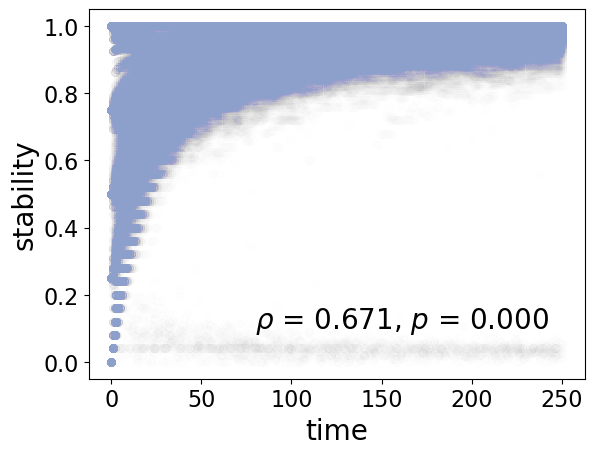

In [2]:
# assembly: time vs stability
def main(c_list=[1.00, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    stability=[]
    time=[]
    for i in range(len(c_list)):
        connect=c_list[i]
        for j in range(replicate):
            os.chdir(str('./connectance%.2f/replicate%d'%(connect, j)))
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(mu_list)):
                    mu=mu_list[l]
                    os.chdir(str('./rho%.2f_mu%.2f/assembly' %(rho, mu)))
                    stab=np.loadtxt('stability_new.csv', delimiter=',').tolist()
                    stability.extend(stab)
                    time.extend(np.linspace(0,len(stab)-1, len(stab)).tolist())
                    os.chdir('../../')
            os.chdir('../../')
    return pd.DataFrame({'stability':stability, 'time':time})
df=main()
plt.scatter(df['time'], df['stability'], color='#8da0cb',alpha=0.005)
rho, p=sp.stats.spearmanr(df['time'], df['stability'])
print([rho, p])
plt.xlabel('time', fontsize=20)
plt.ylabel('stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(x=80, y=0.1, s=str(r'$\rho$ = %.3f, $p$ = %.3f' %(rho, p)), fontsize=20)
plt.gca().set_rasterized(True)
#plt.savefig('Assembly_StabilityTime.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

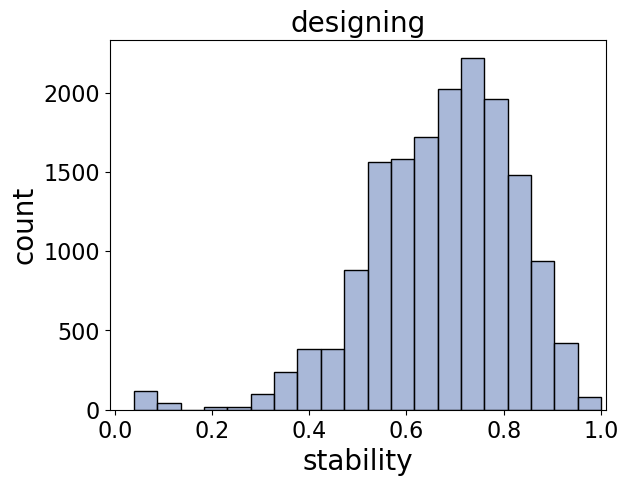

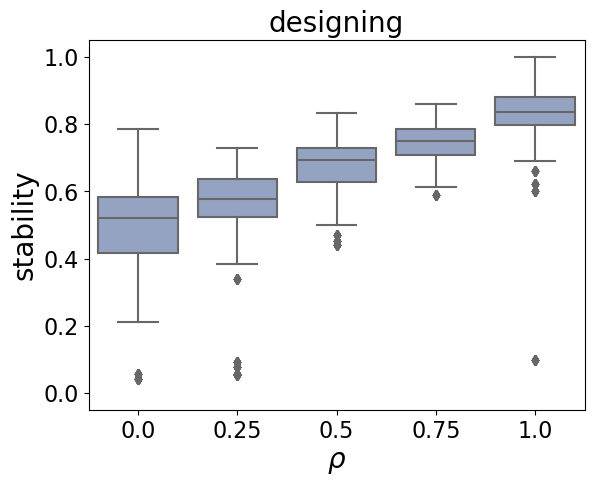

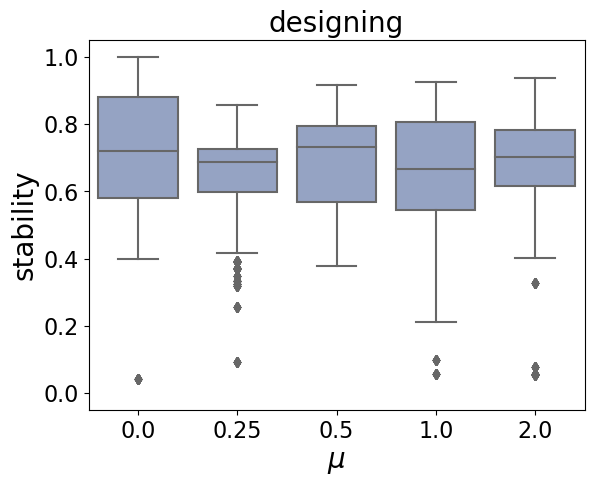

Optimization terminated successfully.
         Current function value: 0.534706
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         full_stability   No. Observations:                16160
Model:                          Logit   Df Residuals:                    16157
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                 -0.6830
Time:                        13:54:28   Log-Likelihood:                -8640.8
converged:                       True   LL-Null:                       -5134.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7716      0.018     43.783      0.000       0.737       0.806
rho            0.5572      0.

In [5]:
#----------- Designing scenario --------------
sns.histplot(data=df_design,x='full_stability', bins=20, color='#8da0cb')
plt.xlim(-0.01, 1.01)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('stability', fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title("designing", fontsize=20)
#plt.savefig("stability_full_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()
# stability against rho, or mu
#sns.stripplot(data=df_design,x='rho',y='stability', alpha=0.03, color='#80b1d3')
sns.boxplot(data=df_design,x='rho',y='full_stability', color='#8da0cb')
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.title("designing", fontsize=20)
#plt.savefig("stability_rho_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#sns.stripplot(data=df_design,x='mu',y='stability', alpha=0.03, color='#80b1d3')
sns.boxplot(data=df_design,x='mu',y='full_stability', color='#8da0cb')
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('stability', fontsize=20)
plt.xlabel(r"$\mu$", fontsize=20)
plt.title("designing", fontsize=20)
#plt.savefig("stability_mu_design.pdf", pad_inches=0.1, bbox_inches='tight' )
plt.show()

#-------------Stat analysis stability ~ rho and mu-----------
#need standarization 
y=df_design.iloc[:, 0] # target
X=df_design.iloc[:, 2:4] # features
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =df_assembly.columns[2:4])
data=pd.concat((y,Xss), axis=1)
print(smf.logit(formula='full_stability ~ rho + mu', data=data).fit().summary())

In [7]:
# difference in the numbers of data between the two scenarios
U, p=sp.stats.ranksums(df_assembly['full_stability'], df_design['full_stability'], alternative='greater')
print([U,p])
print([df_assembly['full_stability'].median(), df_design['full_stability'].median()])
print([len(df_assembly['full_stability']), len(df_design['full_stability'])])
d, res = cliffs_delta(df_assembly['full_stability'], df_design['full_stability']) # effect size

print(d,res)

[161.8876861562012, 0.0]
[0.949, 0.6915]
[209260, 16160]
0.7631090178214036 large


# Analyzing how comunity features relate to stability

In [8]:
#-------------- Generating dataframe for further analysis----------------
def composition_convert(abundance):
    return abundance>0.00001


def ListToDF(L):
    # converting 2dim array to the following dataframe
    return pd.DataFrame({'stability':L[0], 'index':L[1], 
                            'total_positive_up':L[2], 'total_negative_up':L[3], 'mean_positive_up':L[4], 'mean_negative_up': L[5], 'degree_up':L[6], 
                            'total_positive_down':L[7], 'total_negative_down':L[8], 'mean_positive_down':L[9], 'mean_negative_down': L[10], 'degree_down':L[11],
                            'total_positive_trans':L[12], 'total_negative_trans':L[13], 'mean_positive_trans':L[14], 'mean_negative_trans': L[15], 'degree_trans':L[16],
                        'resistance_invasion':L[17], 'resistance_environment':L[18]})

def Analysis(List, A, r_up, r_down, index, scenario):
    """
    analze structural stabiliy given community parameters
    scenario ==0 => assembly otherwise designing
    """
    stability=[]
    indeces=[]
    total_positive_up=[]
    total_negative_up=[]
    mean_positive_up=[]
    mean_negative_up=[]
    degree_up=[]
    total_positive_down=[]
    total_negative_down=[]
    mean_positive_down=[]
    mean_negative_down=[]
    degree_down=[]
    total_positive_trans=[]
    total_negative_trans=[]
    mean_positive_trans=[]
    mean_negative_trans=[]
    degree_trans=[]
    invasion=[]
    envir=[]
    feature=[stability, indeces, 
            total_positive_up, total_negative_up, mean_positive_up, mean_negative_up, degree_up,
            total_positive_down, total_negative_down, mean_positive_down, mean_negative_down, degree_down,
            total_positive_trans, total_negative_trans, mean_positive_trans, mean_negative_trans, degree_trans,
             invasion, envir]
    
    if scenario==0:
        os.chdir('./assembly')
        abundance=np.loadtxt('abundance.csv', delimiter=',', skiprows=0)
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        invasion_stab=np.loadtxt('invasion_stability.csv', delimiter=',', skiprows=0)
        N=np.size(r_up)
    else:
        os.chdir('./designing2')
        stability=np.loadtxt('stability_new.csv', delimiter=',', skiprows=0)
        down_abundance=np.loadtxt('target_down.csv', delimiter=',', skiprows=0)
        up_abundance=np.loadtxt('upstream_community.csv', delimiter=',', skiprows=0)
        invasion_stab=np.loadtxt('invasion_stability_new.csv', delimiter=',', skiprows=0)
    for t in range(len(stability)):
        if scenario==0:
            #assembly
            if t==0:
                abundance_prev=np.zeros([2*N])
            else:
                abundance_prev=abundance[t-1, :]
            if np.all(abundance[t, :] == abundance_prev) == False:
                # we only analyze the cases where species abundances change from the previous time step
                feature=Network(feature,  stability[t], invasion_stab[t], A, abundance[t, :N], abundance[t, N:], index)
        else:
            # dsigning
            if np.isnan(stability[t])==False:
                # we only consider the case when the  target downstream community is maintained.
                feature=Network(feature,  stability[t], invasion_stab[t], A, up_abundance[t, :], down_abundance, index)
    os.chdir('../')
    if List==[]:
        return feature
    else:
        for i in range(len(List)):
            List[i].extend(feature[i])
        return List
            
def Network(List, stability, invasion_stab, interaction,  up_abundance, down_abundance, index):
    # analyzing species interaction network given community compositions
    up_composition=composition_convert(up_abundance)
    down_composition=composition_convert(down_abundance)
    num=np.size(up_composition)
    
    positive_up=[]# positive interaction among upstream
    negative_up=[]# newgative interaction among upstream
    positive_down=[]# positive interaction among downstream
    negative_down=[]# newgative interaction among downstream
    positive_trans=[]# positive interaction from upstream to downstrea
    negative_trans=[]# newgative interaction from upstream to downstrea
    degree_up=[] # degreee within upstream
    degree_down=[] # degree within donwstream
    degree_trans=[] # degree between streams
    
    for i in range(num):
        # i is recever
        degree_up_count=0
        degree_down_count=0
        degree_trans_count=0
        for j in range(num):
            # upstream
            if i !=j and up_composition[i]==1 and up_composition[j]==1:
                #i and j should be different species and they should exist
                if interaction[i, j]>0:
                    positive_up.append(interaction[i, j])
                    degree_up_count+=1
                elif interaction[i, j]<0:
                    #note that we need to ignore no interactio
                    negative_up.append(- interaction[i, j])  # note that we get the sum of strength of negative interaction
                    degree_up_count+=1
            #downsteram
            if i!=j and down_composition[i]==1 and down_composition[j]==1:
                if interaction[i, j]>0:
                    positive_down.append(interaction[i, j])
                    degree_down_count+=1
                elif interaction[i,j]<0:
                    negative_down.append(- interaction[i, j] )
                    degree_down_count+=1
            # from up to down
            if up_composition[j]==1 and down_composition[i]==1:
                if interaction[i, j]>0:
                    positive_trans.append(interaction[i, j])
                    degree_trans_count+=1
                elif interaction[i,j]<0:
                    negative_trans.append(- interaction[i, j] )
                    degree_trans_count+=1
        # degree
        if up_composition[i]==1:
            degree_up.append(degree_up_count)
        if down_composition[i]==1:
            degree_down.append(degree_down_count)
            degree_trans.append(degree_trans_count)
    # ---------------------adding to List---------------
    List[0].append(stability)
    List[1].append(index)
    List[2].append(np.sum(positive_up))
    List[3].append(np.sum(negative_up))
    List[4].append(np.mean(positive_up))
    List[5].append(np.mean(negative_up))
    List[6].append(np.mean(degree_up))
    List[7].append(np.sum(positive_down))
    List[8].append(np.sum(negative_down))
    List[9].append(np.mean(positive_down))
    List[10].append(np.mean(negative_down))
    List[11].append(np.mean(degree_down))
    List[12].append(np.sum(positive_trans))
    List[13].append(np.sum(negative_trans))
    List[14].append(np.mean(positive_trans))
    List[15].append(np.mean(negative_trans))
    List[16].append(np.mean(degree_trans))
    List[17].append(invasion_stab)
    List[18].append(stability-invasion_stab)
    
    return List
            
    
    

def DataFrameGenerator(c_list, rho, mu, replicate=20):
    """
    generating dataframe containing structural stbaility and 15 features
    c_list: list of connectance in interaction network
    mu, rho: parameter of migration
    """
    assembly=[] # 2dim list
    design=[] #2dim list
    for c in range(len(c_list)):
        connect=c_list[c]
        path=str('./connectance%.2f' %(connect))
        os.chdir(path)
        for i in range(replicate):
            path=str('./replicate%d/rho%.2f_mu%.2f' %(i, rho, mu))
            os.chdir(path)
            A=-np.loadtxt('../interaction.csv', delimiter=',', skiprows=0) # note -A is the correct interaction (as diagonal is 1)
            r_up=np.loadtxt('../growthrate_up.csv', delimiter=',', skiprows=0)
            r_down=np.loadtxt('../growthrate_down.csv', delimiter=',', skiprows=0)
            assembly=Analysis(assembly, A, r_up, r_down, i+c*replicate, 0)
            design=Analysis(design, A, r_up, r_down, i+c*replicate, 1)
            os.chdir('../../')
        os.chdir('../')
    df_assembly=ListToDF(assembly).fillna(0)
    df_design=ListToDF(design)
    return [df_assembly, df_design]

def main(c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]):
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            print([rho, mu])
            df_assembly, df_design=DataFrameGenerator(c_list, rho, mu, replicate=20)
            df_assembly.to_csv(str('assembly_rho%.2f_mu%.2f.csv'%(rho, mu)), index=False)
            df_design.to_csv(str('design2_rho%.2f_mu%.2f.csv'%(rho, mu)), index=False)
    return 0
main()

[0.0, 0.0]


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.0, 0.25]
[0.0, 0.5]
[0.0, 1.0]
[0.0, 2.0]
[0.25, 0.0]
[0.25, 0.25]
[0.25, 0.5]
[0.25, 1.0]
[0.25, 2.0]
[0.5, 0.0]
[0.5, 0.25]
[0.5, 0.5]
[0.5, 1.0]
[0.5, 2.0]
[0.75, 0.0]


KeyboardInterrupt: 

In [ ]:
# get dataframe from csv files
def FullData(scenario, rho_list=[0.0, 0.25, 0.5, 0.75, 1.0],mu_list=[0.0, 0.25, 0.5,1.0, 2.0]):
    if scenario==0:
        header='assembly'
    else:
        header='design2'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            fname=header+str('_rho%.2f_mu%.2f.csv'%(rho, mu))
            df=pd.read_csv(fname).fillna(0)
            df['rho']=np.ones([len(df)])*rho
            df['mu']=np.ones([len(df)])*mu
            if i ==0 and j==0:
                df_new=df
            else:
                df_new=pd.concat([df_new, df], axis=0, ignore_index=True)
    return df_new.reindex(columns=[ 'stability', 'resistance_invasion','resistance_environment',
                'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans',
               'mu', 'rho'])
data=FullData(scenario=1) # use only designing scenario

#Above data lack the infromation of species richness
c_list=[1.0, 0.5, 0.25]
rho_list=[0.0, 0.25, 0.5, 0.75, 1.0]
mu_list=[0.0, 0.25, 0.5, 1.0, 2.0]
rich_up=[]
rich_down=[]
for i in range(len(c_list)):
    connect=c_list[i]
    for j in range(20):
        print([connect, j])
        for k in range(len(rho_list)):
            rho=rho_list[k]
            for l in range(len(mu_list)):
                mu=mu_list[l]
                path=str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/designing2' %(connect, j, rho, mu))
                os.chdir(path)
                rd=np.sum(np.loadtxt('target_down.csv', delimiter=',')>0)
                up=np.loadtxt('upstream_community.csv', delimiter=',')
                stability=np.loadtxt('stability_new.csv', delimiter=',')
                for m in range(len(stability)):
                    if np.isnan(stability[m])==False:
                        rich_down.append(rd)
                        rich_up.append(np.sum(up[m, :]>0))
                os.chdir('../../../../')
data['richness_up']=rich_up
data['richness_down']=rich_down            


#standarize
y=data.iloc[:, 0] # target
y2=data.iloc[:, 1:3]
X=data.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =data.columns[3:])
df_design=pd.concat((y, y2, Xss), axis=1).fillna(0)

In [12]:
os.chdir('../../../../')
os.getcwd()

'/Users/shibasakishota/Desktop/スイス留学/Data/Project4/data'

In [15]:
def FullData(scenario, rho_list=[0.0, 0.25, 0.5, 0.75, 1.0],mu_list=[0.0, 0.25, 0.5,1.0, 2.0]):
    if scenario==0:
        header='assembly'
    else:
        header='design2'
    for i in range(len(rho_list)):
        rho=rho_list[i]
        for j in range(len(mu_list)):
            mu=mu_list[j]
            fname=header+str('_rho%.2f_mu%.2f.csv'%(rho, mu))
            df=pd.read_csv(fname).fillna(0)
            df['rho']=np.ones([len(df)])*rho
            df['mu']=np.ones([len(df)])*mu
            if i ==0 and j==0:
                df_new=df
            else:
                df_new=pd.concat([df_new, df], axis=0, ignore_index=True)
    return df_new.reindex(columns=[ 'stability', 'resistance_invasion','resistance_environment',
                'total_positive_up', 'mean_positive_up', 'total_negative_up', 'mean_negative_up', 'degree_up',
                'total_positive_down','mean_positive_down','total_negative_down','mean_negative_down',  'degree_down',
                'total_positive_trans', 'mean_positive_trans',  'total_negative_trans', 'mean_negative_trans' ,  'degree_trans',
               'mu', 'rho'])
df_assembly=FullData(scenario=0)
df_design=FullData(scenario=1)
U, p=sp.stats.ranksums(df_assembly['total_positive_trans'], df_design['total_positive_trans'], alternative='greater')
print([U,p])
print([df_assembly['total_positive_trans'].median(), df_design['total_positive_trans'].median()])
d, res = cliffs_delta(df_assembly['total_positive_trans'], df_design['total_positive_trans'],)

print(d,res)


[95.61579615626202, 0.0]
[5.9442580000000005, 1.132122]
0.4181601109563749 medium


In [ ]:
# causal inference


# effect from richness_up
model1=smf.logit('stability ~richness_up+richness_down+rho+mu+rho', df_design).fit()
print(model1.summary())


# effects from positive/negative_up
model2=smf.logit('stability ~richness_up+total_positive_up+total_negative_up+richness_down+rho+mu', df_design).fit()
print(model2.summary())


# effects from positive/negative_trans
odel3=smf.logit('stability ~richness_up+total_positive_trans+richness_down+rho+mu', 
                 df_design).fit()
print(model3.summary())

# Manipulating communities

In [ ]:
# manipulating species richness
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] + np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]+np.dot(A[i, :], x[:N_up]) + np.dot( A[i, :N_down], x[N_up:]))
    return dx
def Positive_trans(abundance, N, interaction):
    ans=0.0
    for i in range(N):
        if abundance[i]>pow(10,-5):
            for j in range(N):
                if abundance[N+j]>pow(10,-5):
                    if interaction[j,i]>0:
                        ans+=interaction[j,i]
    return ans
    
def Invasion(invader, N, x_full, r_up, r_down, A):

        inv=np.zeros([2*N])
        inv[invader]=inv[invader]+0.01
        sol=solve_ivp(ODE_structured, [0, 300], y0=x_full+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r_up, r_down, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        sol_down=sol.y[:,-1]
        for k in range(np.size(sol_down)):
            if sol_down[k]<pow(10, -6):
                sol_down[k]=0

        return np.all(Comp(sol_down[N:])==Comp(x_full[N:]))
    
def Stability(x_full, r_up, r_down, A, rho, mu):
    """
    Caltulkating stability of downstream

    Parameters
    ----------
    x : 1dim array of species abundances in up/downstream communities
    r_up : 1dim array of growth vector in upsteam 
    r_down : 1dim array of grwoth vector in downstream
    A : 2dim array for species interaction (minus A is interaction matrix)
    rho : parmater for migration from pool to upstream vs to downstream
    mu : parmater for migration from upstream to downstream

    Returns  exact stability
    -------

    """
    N=np.size(r_up)
    p=np.zeros([2*N])
    # probabilities to migration to upstream and dowstream community
    for i in range(np.size(p)):
        if i<N:
            # migration to upstream
            p[i]=rho
        else:
            #migration to downstream
            p[i] = 1-rho + mu* (Comp(x_full[i-N]))
    # normalize
    p=p/np.sum(p)
    stability=0.0
    inv_stability=0.0
    # invasion_upstream
    for i in range(N):
        # invasion to upstream
        stability+=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
    for i in range(N, 2*N):
        # invasion to downstream
        add=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
        stability+=add
        inv_stability+=add
    return stability
           
def Manipulation_add(r_up, r_down, interaction, stability, abundance, N, rho, mu):
    diff_positive=[]
    diff_stability=[]
    #print([base_stability, base_richness, base_positive])
    #for t in range(len(stability)-2, -1, -1):
    T=11 # time point to get baseline communities
    """
    Below we introduce species into the upstream 
    """
    base_abundance=abundance[T, :]
    base_stability=stability[T]
    base_positive=Positive_trans(abundance[T, :], N, interaction)
    Add=np.eye(2*N)
    if np.isinf(sp.special.logit(base_stability))==False and np.sum(Comp(base_abundance[N:]))>0:
        # we should not consider the cases where the original stability is 1 (then we canot increase stability)
        # in addition, we should omit he
        for i in range(N):
            if Comp(base_abundance[i])==False:
                #species i is absent
                x=base_abundance+0.01*Add[i, :]
                sol=solve_ivp(ODE_structured, [0, 300], y0=x, 
                    method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                    args=[r_up, r_down, interaction])# ODE
                if np.all(Comp(sol.y[:, -1]) == Comp(x)):
                    # stability check
                    stability_new=Stability(sol.y[:, -1], r_up, r_down, interaction, rho, mu)
                    #diff_stability.append(stability_new-base_stability)
                    #below use logit instead of stability
                    diff_stability.append(sp.special.logit(stability_new)-sp.special.logit(base_stability))
                    diff_positive.append(Positive_trans(sol.y[:, -1], N, interaction)-base_positive)
    #print([diff_stability, diff_positive])
    return [diff_stability, diff_positive]


def Manipulation_remove(r_up, r_down, interaction, stability, abundance, N, rho, mu):
    diff_positive=[]
    diff_stability=[]
    #print([base_stability, base_richness, base_positive])
    #for t in range(len(stability)-2, -1, -1):
    T=11 # time point to get baseline communities
    """
    Below we remove species from the upstream 
    """
    base_abundance=abundance[T, :]
    base_stability=stability[T]
    base_positive=Positive_trans(abundance[T, :], N, interaction)
    R=np.eye(2*N)
    if np.isinf(sp.special.logit(base_stability))==False and np.sum(Comp(base_abundance[N:]))>0:
        # we should not consider the cases where the original stability is 1 (then we canot increase stability)
        # in addition, we should omit he
        for i in range(N):
            if Comp(base_abundance[i])==True:
                #species i is absent
                x=base_abundance-R[i,:]*base_abundance[i]
                #print(x[:N])
                sol=solve_ivp(ODE_structured, [0, 300], y0=x, 
                    method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                    args=[r_up, r_down, interaction])# ODE
                if np.all(Comp(sol.y[:, -1]) == Comp(x)):
                    # stability check
                    stability_new=Stability(sol.y[:, -1], r_up, r_down, interaction, rho, mu)
                    #diff_stability.append(stability_new-base_stability)
                    #below use logit instead of stability
                    diff_stability.append(sp.special.logit(stability_new)-sp.special.logit(base_stability))
                    diff_positive.append(Positive_trans(sol.y[:, -1], N, interaction)-base_positive)
    #print([diff_stability, diff_positive])
    return [diff_stability, diff_positive]
                         
            
                  


def main (c_list=[1.0, 0.5, 0.25], rho_list=[0.0, 0.25, 0.5, 0.75, 1.0], mu_list=[0, 0.25, 0.5, 1.0, 2.0], replicate=20):
    diff_stability_list=[]
    diff_positive_list=[]
    
    for i in range(len(c_list)):
        connect=c_list[i]
        print(i)
        for j in range( replicate):
            print(j)
            for k in range(len(rho_list)):
                rho=rho_list[k]
                for l in range(len(rho_list)):
                    mu=mu_list[l]
                    if mu>0 or rho<1:
                        # we should not consider the case where the downstream is empy
                        os.chdir(str('./connectance%.2f/replicate%d/rho%.2f_mu%.2f/assembly' %(connect, j, rho, mu)))
                        r_up=np.loadtxt('../../growthrate_up.csv', delimiter=',')
                        r_down=np.loadtxt('../../growthrate_down.csv', delimiter=',')
                        N=np.size(r_down)
                        interaction=-np.loadtxt('../../interaction.csv', delimiter=',')
                        stability=np.loadtxt('stability_new.csv', delimiter=',')
                        abundance=np.loadtxt('abundance.csv',delimiter=',')
                        # run either of below
                        [diff_stability, diff_positive] = Manipulation_add(r_up, r_down, interaction, stability, abundance, N, rho, mu)
                        #[diff_stability, diff_positive] = Manipulation_remove(r_up, r_down, interaction, stability, abundance, N, rho, mu)
                        
                        diff_stability_list.extend(diff_stability)
                        diff_positive_list.extend(diff_positive)
                        os.chdir('../../../../')
    df=pd.DataFrame({'diff_LogOdds':diff_stability_list, 
                     'diff_positive':diff_positive_list})
    df.to_csv('Assembly_Manipulation_add.csv', index=False)
    #df.to_csv('Assembly_Manipulation_remove.csv', index=False)
    return df
#df=main(replicate=20)

In [ ]:
df=pd.concat([df1,df2]).dropna()
#df
plt.scatter(df1.iloc[:, 1], df1.iloc[:, 0],  
            color='#8da0cb',alpha=0.5, label='add')
plt.scatter(df2.iloc[:, 1], df2.iloc[:, 0],  
            color='#fc8d62',alpha=0.5, label='remove')
plt.ylabel('$\Delta$ logit(stability)', fontsize=20)
plt.xlabel('$\Delta$ total_positive_trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(0, color='k')
plt.axhline(y=0, color='k')
#plt.ylim(-5,7)
plt.legend(loc='best', fontsize=16)
plt.gca().set_rasterized(True)
plt.savefig('Assemble_Manipulation_AddRemove.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
print(sp.stats.spearmanr(df.iloc[:, 0], df.iloc[:, 1]))

plt.hist([df1.dropna().iloc[:, 0], df2.dropna().iloc[:, 0]], range=(-5, 35), alpha=0.5,bins=40,
         color=['#8da0cb','#fc8d62'], label=['add', 'remove'])
#plt.hist(, range=(-5, 35), alpha=0.5,bins=40,color='#8da0cb', label='add')
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel('$\Delta$ logit(stability)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.legend(loc='best', fontsize=16)
plt.savefig('Assemble_Manipulation_AddRemove_hist.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
# manipulating interaction from up to down
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)

def ODE_structured(t,x,  r_up, r_down, A):
    # THIS IS A SPECIAL VERSION FOR THE MANIPULATION_POSITIVE
    dx=np.zeros([np.size(x)])
    N_up=np.size(r_up)
    N_down=np.size(r_down)
    # Note N_up == N_down
    for i in range(N_up):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r_up[i] + np.dot(A[i, :], x[:N_up]))
    for i in range(N_down):
        if x[i+N_up]>pow(10, -6):
            dx[i+N_up]=x[i+N_up]*(r_down[i]+np.dot(A[i, :], x[:N_up]) + np.dot( A[i, :N_down], x[N_up:]))
    return dx

def ODE_control(t,x, r, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    for i in range(np.size(x)):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r[i] + np.dot(A[i, :], x))
    return dx

def Community_sampler(N=8, Count=11):
    count=0
    #os.mkdir('./Manipulation_positive')
    os.chdir('./Manipulation_positive')
    while count<Count:
        # we generate communitoes that N species coexist without commnities
        # sample parameter values
        r_up=np.random.uniform(0, 2, N)
        r_down=np.random.uniform(0, 2, N)
        A=np.random.normal(loc=0, scale=0.25, size=(N, N))# note: we use A as interactionmatrix, not competition
        for i in range(N):
            A[i,i]=-1
        # run ode
        init=np.ones([N])*0.01
        sol1=solve_ivp(ODE_control, [0, 300], y0=init,
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r_up, A])# ODE integ
        sol2=solve_ivp(ODE_control, [0, 300], y0=init,
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r_down, A])# ODE integ
        
        if np.all(Comp(init)==Comp(sol1.y[:, -1]))==True and np.all(Comp(init)==Comp(sol2.y[:, -1]))==True:
            print('Find!')
            np.savetxt(str('growth_up%d.csv' %(count)), r_up, delimiter=',')
            np.savetxt(str('growth_down%d.csv' %(count)), r_down, delimiter=',')
            np.savetxt( str('interaction%d.csv' %(count)), A, delimiter=',')
            count+=1
        else:
            print('Failed')

def Invasion(invader, N, x_full, r_up, r_down, A):

        inv=np.zeros([2*N])
        inv[invader]=inv[invader]+0.01
        sol=solve_ivp(ODE_structured, [0, 300], y0=x_full+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r_up, r_down, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        sol_down=sol.y[:,-1]

        return np.all(Comp(sol_down[N:])==Comp(x_full[N:]))
    
def Stability(x_full, r_up, r_down, A, rho, mu):
    """
    Caltulkating stability of downstream

    Parameters
    ----------
    x : 1dim array of species abundances in up/downstream communities
    r_up : 1dim array of growth vector in upsteam 
    r_down : 1dim array of grwoth vector in downstream
    A : 2dim array for species interaction (minus A is interaction matrix)
    rho : parmater for migration from pool to upstream vs to downstream
    mu : parmater for migration from upstream to downstream

    Returns  exact stability
    -------

    """
    N=np.size(r_up)
    p=np.zeros([2*N])
    # probabilities to migration to upstream and dowstream community
    for i in range(np.size(p)):
        if i<N:
            # migration to upstream
            p[i]=rho
        else:
            #migration to downstream
            p[i] = 1-rho + mu* (Comp(x_full[i-N]))
    # normalize
    p=p/np.sum(p)
    stability=0.0
    inv_stability=0.0
    # invasion_upstream
    for i in range(N):
        # invasion to upstream
        stability+=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
    for i in range(N, 2*N):
        # invasion to downstream
        add=p[i] * Invasion(i, N, x_full, r_up, r_down, A)
        stability+=add
        inv_stability+=add
    return stability
            
def Manipulation(Count=11, rho=0.5, mu=0.5):
    """
    In this casem mean of off-diagonal elements in the interaction matrix =0
    """
    os.chdir('./Manipulation_positive')
    Means=np.array([0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1])
    #Means=np.array([0.0]) #for debug
    for i in range(Count):
        r1_up=np.loadtxt(str('growth_up%d.csv' %(i)),delimiter=',')
        r1_down=np.loadtxt(str('growth_down%d.csv' %(i)),delimiter=',')
        A1=np.loadtxt( str('interaction%d.csv' %(i)), delimiter=',')
        n1=np.size(r1_up)
    
        sol1=solve_ivp(ODE_control, [0, 300], y0=np.ones([n1])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r1_up, A1])# ODE integ
        
        for j in range(Count):
            if i !=j:
                print([i,j])
                r2_up=np.loadtxt(str('growth_up%d.csv' %(j)),delimiter=',')
                r2_down=np.loadtxt(str('growth_down%d.csv' %(j)),delimiter=',')
                A2=np.loadtxt( str('interaction%d.csv' %(j)), delimiter=',')
                N=np.size(r1_up)+np.size(r2_down)
                n2=np.size(r2_down)
                
                sol2=solve_ivp(ODE_control, [0, 300], y0=np.ones([n2])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r2_down, A2])# ODE integ
            
                stability_list=[]
                positive_list=[]
                #C=np.random.normal(loc=0, scale=0.25, size=(n1, n2))
                r_up=np.concatenate((r1_up, r2_up))
                r_down=np.concatenate((r1_down, r2_down)) 
                #C=np.zeros([n1, n2])
                #np.savetxt(str('Interaction_fromDown%d_toUp%d.csv' %(j, i)), C, delimiter=',')
                for k in range(np.size(Means)):
                    #print(k)
                    Interaction=np.zeros([N,N])
                    Interaction[:n1, :n1]=A1*1
                    Interaction[n1:, n1:]=A2*1
                    """
                    We assume only positive interactions from up to down
                    To keep mean of interactions 0, interactions from down to up is negative
                    
                    """
                    Interaction[n1:, :n1]=halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n2,n1)) #from up to down
                    #Interaction[:n1, n1:]=C*1
                    Interaction[:n1, n1:]=-halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n1,n2)) #when down invade up
                    init=np.concatenate((sol1.y[:, -1],np.zeros(n2),
                                         np.zeros(n1), sol2.y[:, -1]))
                    #print(init)
                    
                    sol=solve_ivp(ODE_structured, [0, 300], 
                        y0=init, 
                        method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                        args=[r_up, r_down, Interaction])# ODE
                    # coexistence check
                    if np.all(Comp(init)==Comp(sol.y[:, -1])):
                        #print(sol.y[:, -1])
                        # stability check
                        stability=Stability(sol.y[:, -1], r_up, r_down, Interaction, rho, mu)
                        stability_list.append(stability)
                        positive_list.append(np.sum(Interaction[n1:, :n1]))
                    else:
                        #print(sol.y[:, -1])
                        stability_list.append(np.nan)
                        positive_list.append(np.nan)
                #print([stability_list, positive_list])
                df=pd.DataFrame({'stability':stability_list, 
                                 'positive_trans':positive_list,
                                 'mean':Means})
                df.to_csv(str('stabilities_Up%d_Down%d.csv' %(i,j)),index=False)
                    
                    
                
                        
def Manipulation2(Count=11, rho=0.5, mu=0.5):
    """
    in this case we have no species interactions from downstream species to upstream one
    """
    os.chdir('./Manipulation_positive2')
    Means=np.array([0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1])
    #Means=np.array([0.0]) #for debug
    for i in range(Count):
        r1_up=np.loadtxt(str('growth_up%d.csv' %(i)),delimiter=',')
        r1_down=np.loadtxt(str('growth_down%d.csv' %(i)),delimiter=',')
        A1=np.loadtxt( str('interaction%d.csv' %(i)), delimiter=',')
        n1=np.size(r1_up)
    
        sol1=solve_ivp(ODE_control, [0, 300], y0=np.ones([n1])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r1_up, A1])# ODE integ
        
        for j in range(Count):
            if i !=j:
                print([i,j])
                r2_up=np.loadtxt(str('growth_up%d.csv' %(j)),delimiter=',')
                r2_down=np.loadtxt(str('growth_down%d.csv' %(j)),delimiter=',')
                A2=np.loadtxt( str('interaction%d.csv' %(j)), delimiter=',')
                N=np.size(r1_up)+np.size(r2_down)
                n2=np.size(r2_down)
                
                sol2=solve_ivp(ODE_control, [0, 300], y0=np.ones([n2])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r2_down, A2])# ODE integ
            
                stability_list=[]
                positive_list=[]
                
                r_up=np.concatenate((r1_up, r2_up))
                r_down=np.concatenate((r1_down, r2_down)) 
                
                for k in range(np.size(Means)):
                    #print(k)
                    Interaction=np.zeros([N,N])
                    Interaction[:n1, :n1]=A1*1
                    Interaction[n1:, n1:]=A2*1
                    """
                    We assume only positive interactions from up to down
                    To keep mean of interactions 0, interactions from down to up is negative
                    
                    """
                    Interaction[n1:, :n1]=halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n2,n1)) #from up to down
                    #Interaction[:n1, n1:]=-halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n1,n2)) #when down invade up
                    init=np.concatenate((sol1.y[:, -1],np.zeros(n2),
                                         np.zeros(n1), sol2.y[:, -1]))
                    #print(init)
                    
                    sol=solve_ivp(ODE_structured, [0, 300], 
                        y0=init, 
                        method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                        args=[r_up, r_down, Interaction])# ODE
                    # coexistence check
                    if np.all(Comp(init)==Comp(sol.y[:, -1])):
                        #print(sol.y[:, -1])
                        # stability check
                        stability=Stability(sol.y[:, -1], r_up, r_down, Interaction, rho, mu)
                        stability_list.append(stability)
                        positive_list.append(np.sum(Interaction[n1:, :n1]))
                    else:
                        #print(sol.y[:, -1])
                        stability_list.append(np.nan)
                        positive_list.append(np.nan)
                #print([stability_list, positive_list])
                df=pd.DataFrame({'stability':stability_list, 
                                 'positive_trans':positive_list,
                                 'mean':Means})
                df.to_csv(str('stabilities_Up%d_Down%d.csv' %(i,j)),index=False)
                
def Manipulation3(Count=11, rho=0.5, mu=0.5):
    """
    in this case we have no species interactions from downstream species to upstream one
    """
    os.chdir('./Manipulation_positive3')
    Means=np.array([0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1])
    #Means=np.array([0.0]) #for debug
    for i in range(Count):
        r1_up=np.loadtxt(str('growth_up%d.csv' %(i)),delimiter=',')
        r1_down=np.loadtxt(str('growth_down%d.csv' %(i)),delimiter=',')
        A1=np.loadtxt( str('interaction%d.csv' %(i)), delimiter=',')
        n1=np.size(r1_up)
    
        sol1=solve_ivp(ODE_control, [0, 300], y0=np.ones([n1])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r1_up, A1])# ODE integ
        
        for j in range(Count):
            if i !=j:
                print([i,j])
                r2_up=np.loadtxt(str('growth_up%d.csv' %(j)),delimiter=',')
                r2_down=np.loadtxt(str('growth_down%d.csv' %(j)),delimiter=',')
                A2=np.loadtxt( str('interaction%d.csv' %(j)), delimiter=',')
                N=np.size(r1_up)+np.size(r2_down)
                n2=np.size(r2_down)
                
                sol2=solve_ivp(ODE_control, [0, 300], y0=np.ones([n2])*0.01, 
                  method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                  args=[r2_down, A2])# ODE integ
            
                stability_list=[]
                positive_list=[]
                
                r_up=np.concatenate((r1_up, r2_up))
                r_down=np.concatenate((r1_down, r2_down)) 
                
                for k in range(np.size(Means)):
                    #print(k)
                    Interaction=np.zeros([N,N])
                    Interaction[:n1, :n1]=A1*1
                    Interaction[n1:, n1:]=A2*1
                    """
                    We assume only positive interactions from up to down
                    To keep mean of interactions 0, interactions from down to up is negative
                    
                    """
                    Interaction[n1:, :n1]=halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n2,n1)) #from up to down
                    #Interaction[:n1, n1:]=-halfnorm.rvs(loc=Means[k], scale=Means[k],size=(n1,n2)) #when down invade up
                    init=np.concatenate((sol1.y[:, -1],np.zeros(n2),
                                         np.zeros(n1), sol2.y[:, -1]))
                    #print(init)
                    
                    sol=solve_ivp(ODE_structured, [0, 300], 
                        y0=init, 
                        method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                        args=[r_up, r_down, Interaction])# ODE
                    # coexistence check
                    if np.all(Comp(init)==Comp(sol.y[:, -1])):
                        #print(sol.y[:, -1])
                        # stability check
                        stability=Stability(sol.y[:, -1], r_up, r_down, Interaction, rho, mu)
                        stability_list.append(stability)
                        positive_list.append(np.sum(Interaction[n1:, :n1]))
                    else:
                        #print(sol.y[:, -1])
                        stability_list.append(np.nan)
                        positive_list.append(np.nan)
                #print([stability_list, positive_list])
                df=pd.DataFrame({'stability':stability_list, 
                                 'positive_trans':positive_list,
                                 'mean':Means})
                df.to_csv(str('stabilities_Up%d_Down%d.csv' %(i,j)),index=False)

In [ ]:
# compare each meta-community

sns.lineplot(data=DF, hue='MetaCommunity',palette='Set2',
                 x='positive_trans', y='stability', marker='o',
                markersize=10, legend=False)
plt.xscale('log')
plt.ylabel('stability', fontsize=20)
plt.xlabel('total_positive_trans', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.5,1)
plt.savefig('Manipulation_Positive.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
# corr
Corr=[]
for i in range(110):
    #print(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0],)
    corr, p =sp.stats.spearmanr(DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 0], 
                                DF.query(str('MetaCommunity==%d'%(i))).iloc[:, 1])
    if np.isnan(corr)==True:
        #no change
        corr=0
    Corr.append(corr)
sns.histplot(Corr,  color='#8da0cb', bins=10)
plt.xlabel('Spearman correlation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-1, 1)
plt.xticks([-1, -0.5, 0.0, 0.5, 1.0])
plt.yticks(fontsize=16)
plt.savefig('Manipulation_Positive_hist.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

# Unstructured/Upstream stability
This is identical to the cases without spatial strucure.
Then we can re-use the data of downstream target communities in the designing scenarios, where species stable coexist in the absent of upstream species: we assume that we have these communities without spatial structures.
Then, we just need to calculate the stability (use the codes above).

Now let us assume that we summarize the data without spatial structure in "design_contol.csv" file.

In [ ]:
# read data
df_control=pd.read_csv('design_control.csv')
#Plot
f, ax = plt.subplots(figsize=(12, 10))
corr=df_control.corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu",annot_kws={"size": 16})
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_control.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
from sklearn.metrics import r2_score
model=smf.logit('stability~richness', df_control).fit()
print(model.summary())
plt.scatter(df_control[['stability']], model.predict(df_control[['richness']]), 
            color='#8da0cb', alpha=1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('estimated stability', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_control[['stability']], model.predict(df_control[['richness']]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
#plt.gca().set_rasterized(True)
plt.savefig('COntrol_Stability_EstimatedByRichness.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
# causality
print(smf.logit('stability~richness', df_control).fit().summary()) # from richness
print(smf.logit('stability~richness+total_positive+total_negative', df_control).fit().summary()) # from positive/negative interactions

# Models for prediction (not causation)

First, we need to general several models.

In [ ]:
# Algorithm for forward search
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels  logistic regression
           with an intercept
           selected by forward selection
           evaluated by psuedo R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            #print(candidate)
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.logit(formula, data).fit().prsquared 
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        #print([best_new_score, best_candidate])
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} ".format(response,
                                   ' + '.join(selected))
    model = smf.logit(formula, data).fit()
    return model

In [ ]:
# Null model
null_model=smf.logit('stability~1', df_design).fit()
print(null_model.summary())
print([null_model.aic, null_model.bic])
#-----------------------------------------------
#Full model
full_model=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up + degree_up + richness_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down + degree_down + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(full_model.summary())
print([full_model.aic,full_model.aic])# AICand BIC
#-----------------------------------------------
#vif check, full model2
#removing: degree_down->'degree_up'->
print(VIF_check(df_design[['total_positive_up','mean_positive_up', 'total_negative_up', 'mean_negative_up',
                'total_positive_down', 'mean_positive_down', 'total_negative_down', 'mean_negative_down',     
                'total_positive_trans', 'mean_positive_trans', 'total_negative_trans', 'mean_negative_trans','degree_trans', 
                'richness_up', 'richness_down', 'mu', 'rho' ]]))

full_model2=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up  + richness_up'+
                     '+ total_positive_down + mean_positive_down + total_negative_down + mean_negative_down  + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(full_model2.summary())
print([full_model2.aic,full_model2.aic])# AICand BIC
#-----------------------------------------------
#forward model
forward_model=forward_selected(df_design.drop(['resistance_invasion', 'resistance_environment'], axis=1), 'stability')
print(forward_model.summary())# which is identical to Full model
print([forward_model.aic, forward_model.bic])
#-----------------------------------------------
# forward model2 
#removing degree_up
print(VIF_check(df_design[['total_positive_up','mean_positive_up', 'total_negative_up', 'mean_negative_up',
                'total_positive_down',  'total_negative_down',     
                'total_positive_trans', 'mean_positive_trans', 'total_negative_trans', 'mean_negative_trans','degree_trans', 
                'richness_up', 'richness_down', 'mu', 'rho' ]]))
forward_model2=smf.logit('stability ~  total_positive_up + mean_positive_up + total_negative_up +mean_negative_up  + richness_up'+
                     '+ total_positive_down  + total_negative_down   + richness_down'+
                '+ total_positive_trans + mean_positive_trans + total_negative_trans + mean_negative_trans + degree_trans'+
               '+mu +rho', df_design).fit()
print(forward_model2.summary())
print([forward_model2.aic,forward_model2.aic])# AICand BIC
#-----------------------------------------------
#backward
#removing:mean_negative_up ->mean_positive_trans->total_positive_down->mean_positive_down
#degree_down-> richness_up ->total_positive_up -> mean_negative_down->richness_down
#mean_negative_trans->mean_positive_up -> total_negative_trans->total_negative_down
#degree_up 
backward_model=smf.logit('stability ~  total_negative_up '+
                '+ total_positive_trans   + degree_trans'+
               '+mu +rho', df_design).fit()
print(backward_model.summary())
print([backward_model.aic,backward_model.aic])# AICand BIC

#AIC check
aics=[null_model.aic, full_model.aic, full_model2.aic, forward_model.aic, forward_model2.aic, backward_model.aic]
pd.DataFrame({'Models':['Null', 'Full_1', 'Full_2', 'Forward_1', 'Forward_2', 'Backward'], 
              'AIC':aics, 'DeltaAIC':aics-np.min(aics)}).sort_values('DeltaAIC')

In [ ]:
# plot against design data
from sklearn.metrics import r2_score

plt.scatter(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by null model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], null_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Null_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by full model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], full_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]), color='#fc8d62', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by full model2', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], full_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Full2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n forward model1', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], forward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]), color='#66c2a5', alpha=0.01)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n forward model2', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], forward_model2.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('Forward2_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.scatter(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]), color='#8da0cb', alpha=0.1)
plt.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
plt.xlabel('true stability', fontsize=20)
plt.ylabel('prediction by \n backward model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
R2=r2_score(df_design.iloc[:, 0], backward_model.predict(df_design.iloc[:, 1:]))
plt.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)
plt.gca().set_rasterized(True)
plt.savefig('backward1_designing.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
# Whether degree_trans has casation on the stability?
data=pd.read_csv('design_data.csv')
#standarize
y=data.iloc[:, 0] # target
y2=data.iloc[:, 1:3]
X=data.iloc[:, 3:] # features but ignore index, resistance to invasion/environmental change
sscaler = preprocessing.StandardScaler()
Xss= sscaler.fit(X).transform(X) # standarized
Xss=pd.DataFrame(Xss, columns =data.columns[3:])
df_design=pd.concat((y, y2, Xss), axis=1).fillna(0)
df_design# standaril data
model=smf.logit('stability ~richness_up+richness_down+degree_trans+mu+rho', 
                 df_design).fit()
print(model.summary())
f, ax = plt.subplots(figsize=(18, 12))
corr=df_design.corr() #pearson corr.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask=mask-np.eye(np.size(corr, axis=0))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax=sns.heatmap(corr, vmin=-1, vmax=1,annot=True,fmt='.2f',mask=mask, cmap="RdBu",annot_kws={"size": 16})
ax.tick_params(axis='both', which='major', rotation =90, labelsize=18)
plt.yticks(rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
plt.savefig('Feature_PearsonCorr_designl.pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
#prediction against subsampled assemble data
np.random.seed(0) 
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
diff1=0
diff2=0
diff3=0
diff4=0
diff5=0
diff6=0
 # remove cases where downstream is absent
flag=0
for i in range(0, 10):
    df=df_assembly.query(str('stability<=%.1f' %((i+1)*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    df=df.query(str('stability>=%.1f' %(i*0.1))).reset_index(drop=True) # conside only stabiliy <0.95
    rand_samp=np.random.randint(low=0, high=len(df), size=100).tolist()
    if flag==0:
        df_sub=df.iloc[rand_samp, :]
        flag=1
    else:
        df_sub=pd.concat([df_sub,df.iloc[rand_samp, :]], axis=0, ignore_index=True)
ax1.scatter(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax1.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax1.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], null_model.predict(df_sub.iloc[:, 1:]))
#ax1.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax2.scatter(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax2.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax2.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], full_model.predict(df_sub.iloc[:, 1:]))
#ax2.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax3.scatter(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]), color='#fc8d62', alpha=0.3)
ax3.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax3.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], full_model2.predict(df_sub.iloc[:, 1:]))
#ax3.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax4.scatter(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax4.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax4.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], forward_model.predict(df_sub.iloc[:, 1:]))
#ax4.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax5.scatter(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]), color='#66c2a5', alpha=0.3)
ax5.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax5.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], forward_model2.predict(df_sub.iloc[:, 1:]))
#ax5.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax6.scatter(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]), color='#8da0cb', alpha=0.3)
ax6.plot(np.linspace(0, 1, 101), np.linspace(0, 1, 101), color='k')
ax6.tick_params(axis='both', which='major', labelsize=16)
#R2=r2_score(df_sub.iloc[:, 0], backward_model.predict(df_sub.iloc[:, 1:]))
#ax6.text(x=0.0, y=0.9, s=str('$R^2$ = %.3f' %(R2)), fontsize=20)

ax1.set_xlabel('true stability', fontsize=20)
ax1.set_ylabel('prediction by null model', fontsize=20)
fig1.gca().set_rasterized(True)
fig1.savefig('Null_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax2.set_xlabel('true stability', fontsize=20)
ax2.set_ylabel('prediction by full model1', fontsize=20)
fig2.gca().set_rasterized(True)
fig2.savefig('Full1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax3.set_xlabel('true stability', fontsize=20)
ax3.set_ylabel('prediction by full model2', fontsize=20)
fig3.gca().set_rasterized(True)
fig3.savefig('Full2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax4.set_xlabel('true stability', fontsize=20)
ax4.set_ylabel('prediction by \n forward model1', fontsize=20)
fig4.gca().set_rasterized(True)
fig4.savefig('Forward1_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax5.set_xlabel('true stability', fontsize=20)
ax5.set_ylabel('prediction by \n forward model2', fontsize=20)
fig5.gca().set_rasterized(True)
fig5.savefig('Forward2_assembly.pdf', pad_inches=0.1, bbox_inches='tight')
ax6.set_xlabel('true stability', fontsize=20)
ax6.set_ylabel('prediction by \n backward model', fontsize=20)
fig6.gca().set_rasterized(True)
fig6.savefig('Backward_assembly.pdf', pad_inches=0.1, bbox_inches='tight')

# Psuedo- Spatial structure model

In [ ]:
# generating psu-do spatiak structuerd community
import random
def Parm_Sample(N, a):
    """
    Sampling parameter values of psudo-structured model
    N number of species 
    a; mean strength of species interactions from species 0 that is not affected by the other specues
    """
    r=np.random.uniform(low=0.1, high=2.0, size=(N)) # grwoth rate
    np.savetxt('growthrate.csv', r, delimiter=',', fmt='%.6f')
    A=np.eye(N) # assuming normal distribution centering 0.0 or off-diagnoal 
    # Note that MINUS A represents interactions
    for k in range(1, N):
        # note that if k==0, this species not interact with the other species
        for l in range(N):
            if k!=l:
                A[k,l] = np.random.normal(loc=0.0, scale=0.25)
   # np.savetxt('interaction.csv', A, delimiter=',', fmt='%.6f')
    return [r, -A] # note that we need negative sign for A

def ResidentGenerate(r, A, N, a):
    """
    r: gorwth vector
    A: species interaction: Note that 0th row has zero elements except for self-regulation
    N: number of species
    """
    count_max=N*(N-1)*(N-2)/6
    count=0
    l=list(range(1, N))
    while count<count_max:
        # generate target community
        L=random.sample(l, 3)
        L.append(0) # target species composition
        y0=np.zeros([N])
        for i in range(len(L)):
            y0[L[i]]=0.01
            if L[i] >0:
                #A[0,0]=-1
                A[ L[i], 0]  = np.sign(a)*sp.stats.beta.rvs(10*abs(a), 10*(1-abs(a))) # the mean strength of species interaction with resident species is fixecd
        # test whether it is feasible
        sol=solve_ivp(ODE_unstructured, [0, 300], y0=y0,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
        y_last=sol.y[:,-1]
        if  np.all(Comp(y_last) == Comp(y0)):
            # we generated target community
            np.savetxt('interaction.csv', A, delimiter=',', fmt='%.6f')
            for i in range(len(y_last)):
                if y_last[i]<pow(10, -5):
                    y_last[i]=0

            return [y_last, A]
        else:
            count+=1
    # we cannot generate target comunity
    return [np.nan, A]
    
def Comp(x):
    # comver abundance data into composition data
    # x should be 1dim array of species abundances
    return x>pow(10, -5)        
    

def ODE_unstructured(t,x,  r, A):
    # note that -A represents intertaction matrix
    dx=np.zeros([np.size(x)])
    for i in range(len(dx)):
        # upstream community
        if x[i]>pow(10, -6):
            dx[i] = x[i]*(r[i] + np.dot(A[i, :], x))
    return dx

def Stability(resident, r, A):
    stability=0
    N=np.size(r)
    for n in range(N):
        inv=np.zeros([N])
        inv[n]=0.01
        sol=solve_ivp(ODE_unstructured, [0, 300], y0=resident+inv,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
        # check whetehr invasion does not affect the composition od downstream
        y_last=sol.y[:,-1]
        if  np.all(Comp(y_last) == Comp(resident)):
            # species composition is maintained
            stability+=1
    return stability/N
def Interaction(a, resident):
    ans=0.0
    for i in range(1, len(resident)):
        # we ignore self-interaction term i=0
            if resident[i]>pow(10, -5):
                ans+=a[i]
    return ans
def main(N=25):
    stability=[]
    total_interaction=[]
    path='./Psudo_Spatial'
    if not os.path.exists(path):
        os.mkdir(path)
    os.chdir(path)
    replicate=30 # number of generate communities
    mean_strength=np.array([-0.9, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 0.9])
    for i in range (len(mean_strength)) :
        a=mean_strength[i]
        path1=str('./Mean%.1f' %(a))
        os.mkdir(path1)
        os.chdir(path1)
        for j in range (replicate):
            path2=str('./Sample%d' %(j))
            os.mkdir(path2)
            os.chdir(path2)
            print(str("strength %.1f, replicate %d" %(a, j)))
            # generate species interaction matrix and growth rate
            r, A=Parm_Sample(N,a)
            # generate resident community
            resident, A = ResidentGenerate(r, A, N, a) # also update interaction matrix A
            # invasion and stability analsis
            #print(resident)
            if not np.any(np.isnan(resident)):
                np.savetxt('resident.csv', resident, delimiter=',', fmt='%.6f')
                s=Stability(resident, r, A)
                stability.append(s)
                total_interaction.append(Interaction(A[:, 0], resident))
            os.chdir('../')
        os.chdir('../')
    os.chdir('../')
    df=pd.DataFrame(data={"interaction":total_interaction, "stability":stability})
    return df
#---- difference in stability with and without species 0
def Diff_stab():
    stability=[]
    path='./Psudo_Spatial'
    os.chdir(path)
    df=pd.read_csv('Pseudo-Spatial.csv')
    replicate=30 # number of generate communities
    mean_strength=np.array([-0.9, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 0.9])
    for i in range (len(mean_strength)) :
        a=mean_strength[i]
        path1=str('./Mean%.1f' %(a))
        os.chdir(path1)
        for j in range (replicate):
            path2=str('./Sample%d' %(j))
            os.chdir(path2)
            print(str("strength %.1f, replicate %d" %(a, j)))
            # read csv files
            r=np.loadtxt('growthrate.csv', delimiter=',')
            A=np.loadtxt('interaction.csv', delimiter=',')
            resident=np.loadtxt('resident.csv')
            # Remove species 0
            r=r[1:]
            A=A[1:, 1:]
            resident=resident[1:]
            # update resident species abundances
            sol=solve_ivp(ODE_unstructured, [0, 300], y0=resident,
                      method='LSODA',t_eval=np.linspace(0, 300, 30001), 
                      args=[r, A])# ODE integ
            y_last=sol.y[:,-1]
            if np.all(Comp(y_last) == Comp(resident)):
                s=Stability(resident, r, A)
                stability.append(s*25/24) # consider the effect of removing species 0
            else:
                stability.append(np.nan)
            os.chdir('../')
        os.chdir('../')
    os.chdir('../')
    df['new_stability']=stability 
    return df

#------------------------------------
df=main()
df_new=Diff_stab()
df_new['Diff']=df_new['stability']-df_new['new_stability']
# plot histgram
sns.histplot(df_positive['Diff'],  color='#8da0cb', binwidth=0.05, binrange=(-0.3, 0.8), label='positive')
sns.histplot(df_negative['Diff'],color='#fc8d62',  binwidth=0.05,binrange=(-0.3, 0.8), label='negative', alpha=0.5, )
plt.xlim(-0.3, 0.8)
plt.xlabel('Difference in stability', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Psuedo_Spatial_DiffStability.pdf',  pad_inches=0.1, bbox_inches='tight')
plt.show()

# scatter plot
# correlation between stability and interaction
sns.scatterplot(data=df_new, x='interaction', y='Diff', color='#8da0cb', s=40)
plt.axvline(0, color='k', linestyle='--', linewidth=3)
plt.axhline(0, color='k', linestyle='--', linewidth=3)
plt.xlabel('Sum of interactions from Sp.0', fontsize=20)
plt.ylabel('Difference in stability', fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-3.5, 3.5)
plt.ylim(-0.25, 1.05)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks(fontsize=16)

dfp=df_positive.dropna()
dfn=df_negative.dropna()
corr_pos, p_pos=sp.stats.spearmanr(dfp['interaction'], dfp['Diff'])
corr_neg, p_neg=sp.stats.spearmanr(dfn['interaction'], dfn['Diff'])

plt.text(x= 1.0, y=0.85, s=str("coeff. =  %.2f \np = %.3f" %(corr_pos, p_pos)), fontsize=16)
plt.text(x=-2.5, y=0.85, s=str("coeff. =  %.2f \np = %.3f" %(corr_neg, p_neg)), fontsize=16)
plt.savefig('./Psudo_Spatial/Psuedo_interaction_DiffStability.pdf',  pad_inches=0.1, bbox_inches='tight')
plt.show()